In [1]:
import pandas as pd
from typing import List, Tuple
import numpy as np

In [2]:
def downsample_timeseries_data(df: pd.DataFrame, 
                                feature_indexes: dict,
                                window_timesteps: dict
                                ) -> dict:
    processed_data = {}

    # Function to downsample the DataFrame
    def downsample(df, window):
        """
        Downsample the DataFrame, taking the mean of each window and setting the 
        index to the maximum timestamp in that window.
        """
        # First, calculate the mean for each window
        mean_df = df.resample(window).mean()

        # Then, find the maximum timestamp in each window
        max_timestamps = df.iloc[:,1].resample(window).apply(lambda x: x.index.max())

        # Set the maximum timestamps as the new index
        mean_df.index = max_timestamps.values

        return mean_df

    for key in feature_indexes:
        processed_data[key] = downsample(df.iloc[:,feature_indexes[key]], window_timesteps[key])

    return processed_data


In [3]:
def slice_timeseries_data(data_to_slice: pd.DataFrame,
                          downsampled_data: pd.DataFrame, 
                            sizes: dict,
                            thresholds: dict) -> np.array:
    
    def get_max_timestamp_less_than(timestamp, df_sel):
    # Find the maximum timestamp less than the given timestamp
        filtered_timestamps = df_sel.index[df_sel.index < timestamp]
        return filtered_timestamps.max() if not filtered_timestamps.empty else None

    def get_preceding_timestamps(timestamp, df_sel, slice_size):
        """
        Retrieve a specified number of timestamps preceding (and excluding) the given timestamp.
        """
        # Find the maximum timestamp less than the given timestamp
        max_less_than_timestamp = get_max_timestamp_less_than(timestamp, df_sel)
        if max_less_than_timestamp is None:
            return pd.DataFrame()  # Return empty DataFrame if no suitable timestamp is found

        # Find the index of this timestamp in df_sel
        closest_idx = df_sel.index.searchsorted(timestamp, side='left')

        # Extract the preceding timestamps
        start_idx = max(closest_idx - slice_size, 0)
        relevant_timestamps = df_sel.iloc[start_idx:closest_idx, :]
        
        return relevant_timestamps  
    
    def get_following_timestamps(timestamp, df_sel, slice_size):
        """
        Retrieve timestamps equal to or greater than the selected timestamp.
        """
        # Find the index of the closest timestamp in df_sel
        closest_idx = df_sel.index.searchsorted(timestamp, side='left')
        
        # Ensure index is within bounds
        if closest_idx >= len(df_sel):
            return pd.DataFrame()  # Return empty DataFrame if index is out of bounds

        # Extract the following timestamps
        end_idx = min(closest_idx + slice_size, len(df_sel))
        relevant_timestamps = df_sel.iloc[closest_idx:end_idx, :]
        
        return relevant_timestamps
    
    def fill_numpy(relevant_timestamps,slice_size, direction):
        # Create a placeholder array
        placeholder_array = np.zeros([slice_size, relevant_timestamps.shape[1]])
        
        # Fill the placeholder array from the bottom
        if direction == "preceding":
            placeholder_array[-len(relevant_timestamps):] = relevant_timestamps.to_numpy()
        else:
            placeholder_array[:len(relevant_timestamps)] = relevant_timestamps.to_numpy()
        
        return placeholder_array
    
    sliced_data = {}
    for key in data_to_slice:
        sliced_data[key] = []
    # To store our last known unnormalized value
    sliced_data['last_known'] = []
    
    selected_timestamps = []
    # Loop through each timestamp in your data_to_slice
    for timestamp in data_to_slice['response'].index:
        
        # Check if we have enough, call, context, and response data. 
        check_size_dict={}
        for key in data_to_slice:
            if key == 'forward':
                check_size_dict[key] = get_following_timestamps(timestamp, data_to_slice[key], sizes[key])
            else:
                check_size_dict[key] = get_preceding_timestamps(timestamp, data_to_slice[key], sizes[key])
            
        size_check = []
        for key, value in check_size_dict.items():
            size_check.append((value.shape[0] / sizes[key]) >= thresholds[key])

        if size_check.count(False)==0:
            # Add timestamp to list
            selected_timestamps.append(timestamp)
    
            for key in check_size_dict:
                if key == 'forward':
                    direction = 'following'
                else:
                    direction = 'preceding'
                # Append the result of get_preceding_timestamps to the list in the dictionary
                sliced_data[key].append(fill_numpy(check_size_dict[key], sizes[key], direction))
            # Include last known value (pre-normalization) from call
            sliced_data['last_known'].append(get_preceding_timestamps(timestamp, downsampled_data['call'], 1))
            
    # After the loop, use np.vstack to combine the arrays for each key
    stacked_arrays_dict = {key: np.stack(value) for key, value in sliced_data.items()}
    
    return stacked_arrays_dict, selected_timestamps

In [4]:

def masked_expand(sliced_data, sizes):
    sizes['response']
    
    expanded_dict = {}
    for key, value in sliced_data.items():
        if key == "response":
            res_shape = value.shape
            response_data = value.reshape(res_shape[0]*res_shape[1],res_shape[2])
            mask_array = np.tile(np.repeat(np.tril(np.ones([res_shape[1],res_shape[1]]),-1)[:,:,np.newaxis], res_shape[2], axis=2), (res_shape[0], 1, 1))
            expanded_dict[key] = np.repeat(value,sizes['response'],axis=0) * mask_array
        else:
            expanded_dict[key] = np.repeat(value,sizes['response'],axis=0)
            
    unmasked_response = np.repeat(sliced_data['response'],sizes['response'],axis=0)
            
    return expanded_dict, response_data, unmasked_response

We will create some functions for coil normalization, where we express the discrete derivative as a superposition of some maximum increase and maximum decrease. 

$$
\Delta_{t}f(t) = f(t+1) - f(t) = a\Delta_{max}-b\Delta_{max}
$$

where 

$$
a + b = 1
$$

It follows that 

$$
a = \frac{\Delta_{t}f(t)+\Delta_{max}}{2\Delta_{max}}
$$

In [5]:
def coil_normalization(df):
    def max_absolute_change(df_diff):
        # Calculate the absolute change for each feature
        abs_change = df_diff.abs()

        # Find the maximum absolute change for each feature
        max_changes = abs_change.max()

        # Convert the series to a DataFrame
        max_change_df = max_changes.to_frame(name='Max Absolute Change')

        return max_change_df
    
    # Calculate the change for each feature
    df_diff = df.diff()
    # Calculate the max absolute change for each feature
    max_change_df = max_absolute_change(df_diff)
    
    normalized_df = pd.DataFrame()

    for column in df_diff.columns:
        max_change_val = max_change_df.loc[column,'Max Absolute Change']
        normalized_df[column] = (df_diff[column] + max_change_val) / (2 * max_change_val)
    # Set first row to 0 as there is no diff
    normalized_df.iloc[0] = normalized_df.iloc[0].fillna(0)
       
    return normalized_df, max_change_df

In [6]:
# Example usage:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'], 
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
df = df.iloc[:5000,:]

In [7]:
normalized_df, max_change_df = coil_normalization(df)
normalized_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:20:00,0.530864,0.375000,0.375796,0.374172,0.50501,0.433333,0.413462,0.493902,0.428571,0.418182,0.635224,0.460459,0.479167,0.477367
2009-01-01 00:30:00,0.475309,0.467949,0.468153,0.490066,0.52505,0.486667,0.490385,0.493902,0.485714,0.490909,0.529024,0.432398,0.427500,0.549598
2009-01-01 00:40:00,0.487654,0.564103,0.566879,0.579470,0.51503,0.533333,0.557692,0.493902,0.557143,0.554545,0.430739,0.519133,0.489167,0.536884
2009-01-01 00:50:00,0.500000,0.512821,0.509554,0.509934,0.49499,0.506667,0.509615,0.500000,0.500000,0.509091,0.487467,0.497449,0.510833,0.522773
2009-01-01 01:00:00,0.493827,0.570513,0.573248,0.586093,0.51503,0.540000,0.557692,0.500000,0.557143,0.554545,0.424802,0.485969,0.500000,0.469822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-02-04 16:40:00,0.500000,0.371795,0.369427,0.456954,0.58016,0.360000,0.451923,0.402439,0.457143,0.445455,0.620053,0.545918,0.551667,0.483039
2009-02-04 16:50:00,0.500000,0.426282,0.423567,0.503311,0.57515,0.420000,0.500000,0.426829,0.500000,0.509091,0.569261,0.473214,0.490000,0.971848
2009-02-04 17:00:00,0.518519,0.500000,0.500000,0.526490,0.52505,0.500000,0.538462,0.475610,0.528571,0.536364,0.500660,0.470663,0.489167,0.489102


We also want to be able to reconstruct the original signal at any point given the last known value and the coil-normalized values. 

In [8]:
def denormalize(normalized_df, max_change_df, initial_value, start_idx, end_idx):
    # Initialize the reconstructed DataFrame with the initial value
    reconstructed_df = pd.DataFrame(index=normalized_df.index[start_idx-1:end_idx])
    for column in normalized_df.columns:
        reconstructed_df[column] = initial_value[column]
        # Iteratively reconstruct the signal
        for i in range(start_idx, end_idx):
            delta_max = max_change_df.loc[column, 'Max Absolute Change']
            delta_t = 2 * normalized_df.at[normalized_df.index[i], column] * delta_max - delta_max
            reconstructed_df.at[normalized_df.index[i], column] = reconstructed_df.at[normalized_df.index[i - 1], column] + delta_t
    reconstructed_df.drop(index=reconstructed_df.index[0], axis=0, inplace=True)
    return reconstructed_df

# Example usage:
# Assuming `df` is the original DataFrame and we want to reconstruct the signal for a specific time window
start_idx = 100
end_idx = 200
initial_value = df.iloc[start_idx-1]  # Last known value before the time window
reconstructed_df = denormalize(normalized_df, max_change_df, initial_value, start_idx, end_idx)
print(reconstructed_df)


                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 17:00:00   1000.21     -5.33    267.82        -6.71    89.9   
2009-01-01 17:10:00   1000.21     -5.39    267.76        -6.79    89.8   
2009-01-01 17:20:00   1000.22     -5.24    267.90        -6.57    90.3   
2009-01-01 17:30:00   1000.22     -5.17    267.98        -6.59    89.7   
2009-01-01 17:40:00   1000.21     -5.17    267.97        -6.64    89.4   
...                       ...       ...       ...          ...     ...   
2009-01-02 08:50:00    998.38     -4.13    269.16        -4.86    94.6   
2009-01-02 09:00:00    998.39     -4.09    269.20        -4.86    94.3   
2009-01-02 09:10:00    998.43     -4.03    269.26        -4.82    94.2   
2009-01-02 09:20:00    998.50     -3.91    269.37        -4.76    93.8   
2009-01-02 09:30:00    998.57     -3.86    269.42        -4.73    93.6   

                     VPmax (mbar)  VP

In [9]:
# Compare the reconstructed data with the original data
original_slice = df.iloc[start_idx:end_idx]
print(original_slice)

                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 16:50:00   1000.13     -5.33    267.82        -6.81    89.2   
2009-01-01 17:00:00   1000.17     -5.37    267.78        -6.82    89.4   
2009-01-01 17:10:00   1000.17     -5.43    267.72        -6.90    89.3   
2009-01-01 17:20:00   1000.18     -5.28    267.86        -6.68    89.8   
2009-01-01 17:30:00   1000.18     -5.21    267.94        -6.70    89.2   
...                       ...       ...       ...          ...     ...   
2009-01-02 08:40:00    998.29     -4.24    269.05        -5.00    94.4   
2009-01-02 08:50:00    998.34     -4.17    269.12        -4.97    94.1   
2009-01-02 09:00:00    998.35     -4.13    269.16        -4.97    93.8   
2009-01-02 09:10:00    998.39     -4.07    269.22        -4.93    93.7   
2009-01-02 09:20:00    998.46     -3.95    269.33        -4.87    93.3   

                     VPmax (mbar)  VP

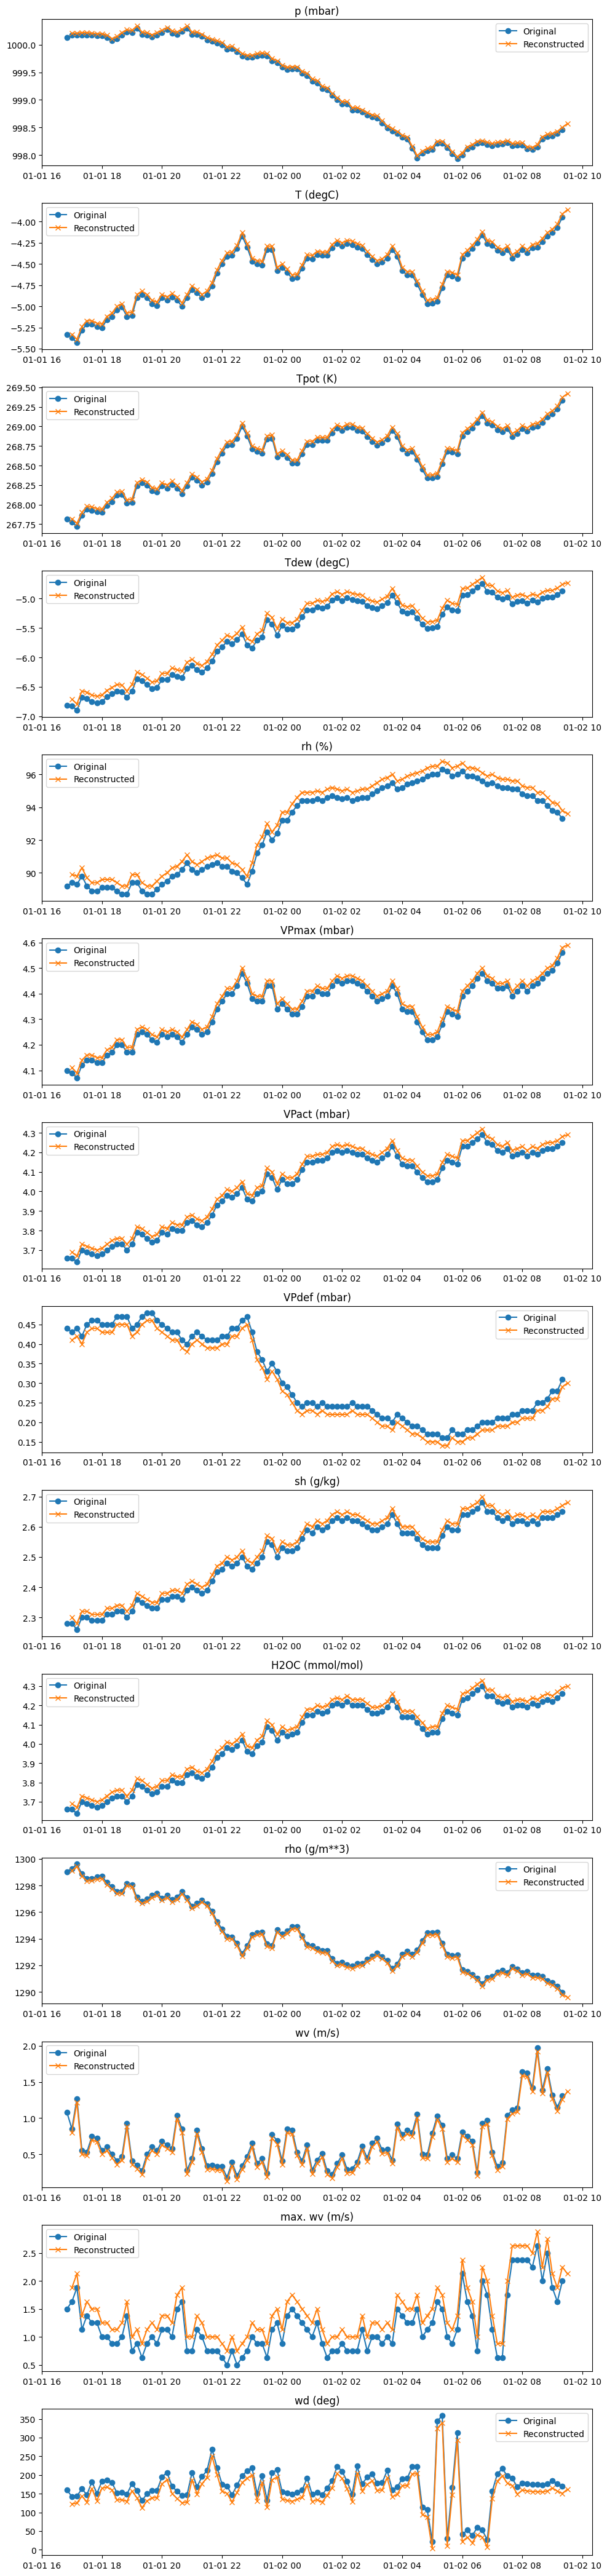

In [10]:
import matplotlib.pyplot as plt

# Assuming original_slice and reconstructed_df are already defined
# Plotting each feature
n_features = len(df.columns)
fig, axes = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

for i, column in enumerate(df.columns):
    axes[i].plot(original_slice.index, original_slice[column], label='Original', marker='o')
    axes[i].plot(reconstructed_df.index, reconstructed_df[column], label='Reconstructed', marker='x')
    axes[i].set_title(column)
    axes[i].legend()

plt.tight_layout()
plt.show()


We can train a model directly on the coil-normalized values, but this does not provide context on the magnitude the signals; just the dynamics. To provide context on the magnitudes we will also min-max scale the data 

In [11]:
def create_min_max_df(df):
    """Create a DataFrame with min and max values for each feature."""
    min_values = df.min()
    max_values = df.max()
    min_max_df = pd.DataFrame({'min': min_values, 'max': max_values})
    return min_max_df

def scale_data(df, min_max_df, feature_range=(0, 1)):
    """Scale data in df based on min-max values and a given feature range."""
    min_scale, max_scale = feature_range
    scaled_df = pd.DataFrame()

    for column in df.columns:
        min_val = min_max_df.loc[column, 'min']
        max_val = min_max_df.loc[column, 'max']
        # Avoid division by zero in case of constant columns
        if max_val != min_val:
            scaled_df[column] = (df[column] - min_val) / (max_val - min_val) * (max_scale - min_scale) + min_scale
        else:
            scaled_df[column] = df[column]

    return scaled_df

Now we will specify our required configurations for Cerberus

In [12]:
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

window_sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)   
}

In [13]:
#Scale Data
min_max_df = create_min_max_df(df)
print(min_max_df)
scaled_df = scale_data(df, min_max_df, feature_range=(0, 1))

                     min      max
p (mbar)          944.58  1005.71
T (degC)          -23.01     7.64
Tpot (K)          250.60   283.19
Tdew (degC)       -25.01     2.51
rh (%)             42.38   100.00
VPmax (mbar)        0.95    10.48
VPact (mbar)        0.79     7.32
VPdef (mbar)        0.00     4.94
sh (g/kg)           0.50     4.80
H2OC (mmol/mol)     0.80     7.69
rho (g/m**3)     1179.43  1383.38
wv (m/s)            0.00     9.71
max. wv (m/s)       0.00    14.50
wd (deg)            0.00   358.90


In [14]:
downsampled_data = downsample_timeseries_data(scaled_df, 
                                        feature_indexes,
                                        window_timesteps)
downsampled_data

{'call':                      p (mbar)  T (degC)  Tpot (K)  Tdew (degC)    rh (%)  \
 2009-01-01 00:10:00  0.849665  0.489070  0.454127     0.585392  0.883721   
 2009-01-01 00:20:00  0.850483  0.476346  0.442160     0.571584  0.885456   
 2009-01-01 00:30:00  0.849828  0.473083  0.439092     0.570494  0.894134   
 2009-01-01 00:40:00  0.849501  0.479608  0.445535     0.579215  0.899341   
 2009-01-01 00:50:00  0.849501  0.480914  0.446456     0.580305  0.897605   
 ...                       ...       ...       ...          ...       ...   
 2009-02-04 16:40:00  0.435302  0.821207  0.829396     0.897892  0.717112   
 2009-02-04 16:50:00  0.435302  0.813703  0.822031     0.898256  0.743145   
 2009-02-04 17:00:00  0.435793  0.813703  0.822031     0.901163  0.751822   
 2009-02-04 17:10:00  0.438737  0.811746  0.820190     0.900073  0.753558   
 2009-02-04 17:20:00  0.442827  0.815661  0.822952     0.904070  0.753558   
 
                      VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh

In [15]:
normalized_data = {}
max_change_dfs = {}
for key in downsampled_data:
    normalized_data[key], max_change_df[key] = coil_normalization(downsampled_data[key])
    
normalized_data['call']

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
2009-01-01 00:20:00,0.530864,0.375000,0.375796,0.374172,0.50501,0.433333,0.413462,0.493902,0.428571,0.418182,0.635224,0.460459,0.479167,0.477367
2009-01-01 00:30:00,0.475309,0.467949,0.468153,0.490066,0.52505,0.486667,0.490385,0.493902,0.485714,0.490909,0.529024,0.432398,0.427500,0.549598
2009-01-01 00:40:00,0.487654,0.564103,0.566879,0.579470,0.51503,0.533333,0.557692,0.493902,0.557143,0.554545,0.430739,0.519133,0.489167,0.536884
2009-01-01 00:50:00,0.500000,0.512821,0.509554,0.509934,0.49499,0.506667,0.509615,0.500000,0.500000,0.509091,0.487467,0.497449,0.510833,0.522773
2009-01-01 01:00:00,0.493827,0.570513,0.573248,0.586093,0.51503,0.540000,0.557692,0.500000,0.557143,0.554545,0.424802,0.485969,0.500000,0.469822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-02-04 16:40:00,0.500000,0.371795,0.369427,0.456954,0.58016,0.360000,0.451923,0.402439,0.457143,0.445455,0.620053,0.545918,0.551667,0.483039
2009-02-04 16:50:00,0.500000,0.426282,0.423567,0.503311,0.57515,0.420000,0.500000,0.426829,0.500000,0.509091,0.569261,0.473214,0.490000,0.971848
2009-02-04 17:00:00,0.518519,0.500000,0.500000,0.526490,0.52505,0.500000,0.538462,0.475610,0.528571,0.536364,0.500660,0.470663,0.489167,0.489102
2009-02-04 17:10:00,0.611111,0.480769,0.480892,0.490066,0.50501,0.480000,0.480769,0.493902,0.485714,0.481818,0.531662,0.460459,0.490000,0.458087


In [16]:
sliced_data, selected_timestamps = slice_timeseries_data(normalized_data,
                                                        downsampled_data,
                                                        sizes,
                                                        thresholds)

In [17]:
for key in sliced_data:
    print(sliced_data[key].shape)

(4749, 24, 14)
(4749, 8, 3)
(4749, 24, 14)
(4749, 12, 14)
(4749, 6, 14)
(4749, 1, 14)


In [18]:
expanded_dict, response_data, unmasked_response = masked_expand(sliced_data, sizes)

print(response_data[0,:])
for ir in range(30):
    print(expanded_dict['response'][ir,:,:])
    
for key in expanded_dict:
    print(expanded_dict[key].shape)
    
print(response_data.shape)

[0.62962963 0.50320513 0.49498998]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0.62962963 0.50320513 0.49498998]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.62962963 0.50320513 0.49498998]
 [0.51851852 0.49679487 0.51503006]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.62962963 0.50320513 0.49498998]
 [0.51851852 0.49679487 0.51503006]
 [0.5308642  0.48717949 0.52004008]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[

# Cerberus Construction

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def ksize(size):
    return max([2, round(size / 9)])

class FormHead(nn.Module):
    def __init__(self, size, feature_len, csize=64, channels=2):
        super(FormHead, self).__init__()
        self.conv = nn.Conv2d(channels, csize, kernel_size=(ksize(size), ksize(feature_len)))
        self.pool = nn.MaxPool2d(2, 2)
        # Placeholder for the linear layer
        self.fc = None

    def forward(self, x):
        x = F.leaky_relu(self.conv(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        if self.fc is None:
            # Dynamically compute the input size for the linear layer
            size = x.size(1)
            self.fc = nn.Linear(size, 64)
        x = F.leaky_relu(self.fc(x))
        return x

class Cerberus(nn.Module):
    def __init__(self, training_data, response_data, csize=64):
        super(Cerberus, self).__init__()
        train_call = training_data['call']
        train_contexts = [training_data[key] for key in training_data if 'context' in key]
        train_response = training_data['response']

        context_dims = [cont.shape for cont in train_contexts]
        call_size, call_fl = train_call.shape[1], train_call.shape[2]
        res_size, res_fl = train_response.shape[1], train_response.shape[2]

        self.call_head = FormHead(call_size, call_fl, csize)
        self.context_heads = nn.ModuleList([FormHead(icl[1], icl[2], csize) for icl in context_dims])
        self.response_head = FormHead(res_size, res_fl, csize)

        self.fc1 = nn.Linear(csize * (2 + len(context_dims)), csize * 16)
        self.fc2 = nn.Linear(csize * 16, csize * 8)
        self.fc3 = nn.Linear(csize * 8 + train_call.shape[2], csize * 4)
        self.fc4 = nn.Linear(csize * 4, csize)
        self.fc5 = nn.Linear(csize, csize // 2)
        self.out = nn.Linear(csize // 2, response_data.shape[1])

    def forward(self, x_call, x_contexts, x_response, x_lastknown):
        call_head_out = self.call_head(x_call)
        context_heads_out = [head(x) for head, x in zip(self.context_heads, x_contexts)]
        response_head_out = self.response_head(x_response)
        
        last_known = x_lastknown
        
        necks = torch.cat([call_head_out] + context_heads_out + [response_head_out], dim=1)
        necks = F.leaky_relu(self.fc1(necks))
        necks = F.leaky_relu(self.fc2(necks))
        body = F.leaky_relu(self.fc3(torch.cat([necks] + [last_known], dim=1)))
        body = F.leaky_relu(self.fc4(body))
        body = F.leaky_relu(self.fc5(body))
        body = self.out(body)
        return body

We can use a nice function to create the PyTorch tensors, where the first channel will be the data we have calculated and the second channel will simply be 1 minus that channel. 

In [20]:
def make_torch_tensor(channel_array):
    first_channel = torch.tensor(channel_array, dtype=torch.float32)

    # Create the second channel as 1 minus the first channel
    second_channel = 1 - first_channel

    # Combine both channels to form a two-channel tensor
    # The unsqueeze(1) adds a channel dimension
    both_channels = torch.stack((first_channel, second_channel), dim=1)
    
    return both_channels

In [21]:
from torch.utils.data import DataLoader, TensorDataset
import random

num_epochs = 30

model = Cerberus(expanded_dict, response_data)

# Define a loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_len = 200
train_index = random.sample(range(train_len),train_len)

# We will convert our numpy arrays to 2-channel tensors
calls = make_torch_tensor(expanded_dict['call'][train_index,:,:])
contexts = [make_torch_tensor(expanded_dict[key][train_index,:,:]) for key in expanded_dict if 'context' in key]
responses = make_torch_tensor(expanded_dict['response'][train_index,:,:][train_index,:,:])

# Last knowns isn't coil-normalized so we won't process it as such
last_knowns = torch.tensor(expanded_dict['last_known'][train_index,0,:], dtype=torch.float32)

y = torch.tensor(response_data[train_index,:], dtype=torch.float32)
batch_size = 100
batch_range = range(0, len(calls), batch_size)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i in batch_range:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(calls[i:i+batch_size], [cont[i:i+batch_size] for cont in contexts], responses[i:i+batch_size],last_knowns[i:i+batch_size])
        loss = criterion(outputs, y[i:i+batch_size])

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(batch_range)}")

Epoch [1/30], Loss: 0.325050950050354
Epoch [2/30], Loss: 0.2997111976146698
Epoch [3/30], Loss: 0.23370502889156342
Epoch [4/30], Loss: 0.12261338904500008
Epoch [5/30], Loss: 0.07545506954193115
Epoch [6/30], Loss: 0.030186478048563004
Epoch [7/30], Loss: 0.004707650979980826
Epoch [8/30], Loss: 0.01190869277343154
Epoch [9/30], Loss: 0.010797938797622919
Epoch [10/30], Loss: 0.009176425635814667
Epoch [11/30], Loss: 0.0031035307911224663
Epoch [12/30], Loss: 0.001508843997726217
Epoch [13/30], Loss: 0.004347722744569182
Epoch [14/30], Loss: 0.0038869515992701054
Epoch [15/30], Loss: 0.002656585187651217
Epoch [16/30], Loss: 0.0009562570776324719
Epoch [17/30], Loss: 0.0011187160853296518
Epoch [18/30], Loss: 0.0016723059234209359
Epoch [19/30], Loss: 0.001348415156826377
Epoch [20/30], Loss: 0.0009285880078095943
Epoch [21/30], Loss: 0.0006522912881337106
Epoch [22/30], Loss: 0.000833110127132386
Epoch [23/30], Loss: 0.0008135133248288184
Epoch [24/30], Loss: 0.0006596285675186664
E

In [22]:
print(np.argwhere(np.isnan(expanded_dict['context_2'])).shape)

print(np.argwhere(np.isnan(sliced_data['context_2'])).shape)

print(np.argwhere(np.isnan(normalized_data['context_2'])).shape)

print(np.argwhere(np.isnan(downsampled_data['context_2'])).shape)

expanded_dict['context_2']


(0, 3)
(0, 3)
(0, 2)
(0, 2)


array([[[0.61792156, 0.54903732, 0.53838827, ..., 0.60984195,
         0.62565686, 0.68419128],
        [0.52278567, 0.61725794, 0.61494084, ..., 0.51156911,
         0.49506081, 0.31093119],
        [0.50158706, 0.55109317, 0.55073251, ..., 0.40576157,
         0.39861817, 0.55244895],
        [0.43938936, 0.5124639 , 0.51783565, ..., 0.50953877,
         0.51710158, 0.5057978 ],
        [0.48785772, 0.52706406, 0.52811133, ..., 0.5973031 ,
         0.58822018, 0.40849887],
        [0.53671655, 0.57280924, 0.56919938, ..., 0.49873583,
         0.51027808, 0.39433126]],

       [[0.61792156, 0.54903732, 0.53838827, ..., 0.60984195,
         0.62565686, 0.68419128],
        [0.52278567, 0.61725794, 0.61494084, ..., 0.51156911,
         0.49506081, 0.31093119],
        [0.50158706, 0.55109317, 0.55073251, ..., 0.40576157,
         0.39861817, 0.55244895],
        [0.43938936, 0.5124639 , 0.51783565, ..., 0.50953877,
         0.51710158, 0.5057978 ],
        [0.48785772, 0.52706406, 0.528